# K-Means Clustering Analysis
### Author: Ben Newell

!pip install folium

In [49]:
#IMPORTING LIBARIES
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium
from folium import plugins
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors

## Plotting the Elbow curve

In [25]:
df = pd.read_csv(r"C:\Users\benne\OneDrive\Desktop\Important things\data science\Group project\datasets\bird_final.csv")

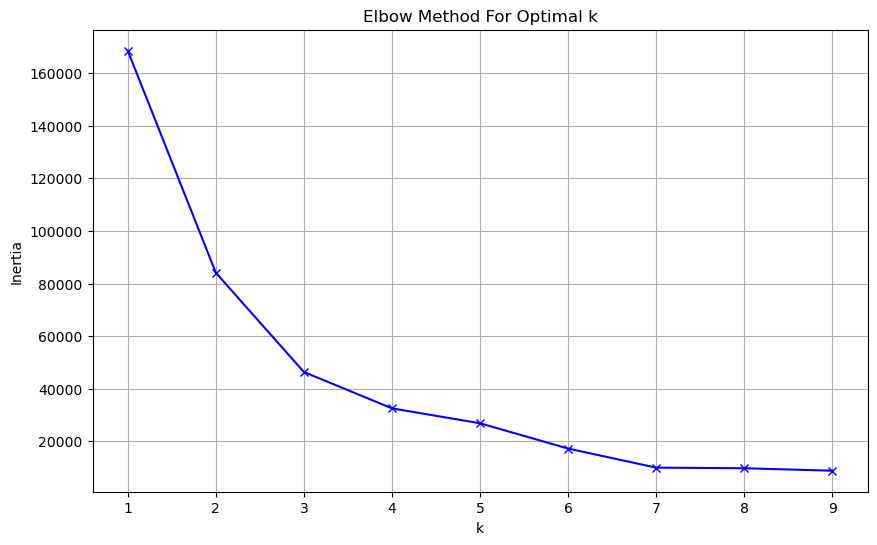

In [27]:
# The Elbow method to find k
# Prepare location data
features_for_clustering = ['LATITUDE', 'LONGITUDE']
clustering_data = df[features_for_clustering].copy()

# Scale the features
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Use elbow method to find optimal number of clusters
inertias = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

***Finding clusters and plotting on the map***

In [29]:
# Finding the clusters and plotting on a world map
# Number of clusters
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Location_Cluster'] = kmeans.fit_predict(clustering_data_scaled)

# Create base map
center_lat = df['LATITUDE'].mean()
center_lon = df['LONGITUDE'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=4)

# Define colors for clusters - Expand the color list to match n_clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 
'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'lightblue', 'lightgreen', 
'gray', 'black', 'lightgray']

# Add points to map
for cluster in range(n_clusters):
    cluster_data = df[df['Location_Cluster'] == cluster]
    # Sample to reduce points for visualization
    sample_size = min(500, len(cluster_data))
    cluster_sample = cluster_data.sample(n=sample_size, random_state=42)
    
    fg = folium.FeatureGroup(name=f'Cluster {cluster}')
    
    for idx, row in cluster_sample.iterrows():
        folium.CircleMarker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            radius=3,
            color=colors[cluster],
            fill=True,
            popup=f'Cluster {cluster}<br>Lat: {row["LATITUDE"]:.2f}<br>Lon: {row["LONGITUDE"]:.2f}',
            opacity=0.7,
            fill_opacity=0.5
        ).add_to(fg)
    
    fg.add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

In [30]:
# Calculate cluster statistics
cluster_stats = df.groupby('Location_Cluster').agg({
    'LATITUDE': ['mean', 'min', 'max'],
    'LONGITUDE': ['mean', 'min', 'max'],
    'OBSERVATION COUNT': ['count', 'mean']
}).round(2)

print("Cluster Statistics:")
print(cluster_stats)

# Print the number of datapoints in each cluster
print("\nNumber of datapoints in each cluster:")
cluster_sizes = df['Location_Cluster'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    print(f"Cluster {cluster}: {size:,} datapoints")

# Calculate the geographic spread of each cluster
print("\nGeographic spread of each cluster (in degrees):")
for cluster in range(n_clusters):
    cluster_data = df[df['Location_Cluster'] == cluster]
    lat_spread = cluster_data['LATITUDE'].max() - cluster_data['LATITUDE'].min()
    lon_spread = cluster_data['LONGITUDE'].max() - cluster_data['LONGITUDE'].min()
    print(f"\nCluster {cluster}:")
    print(f"Latitude spread: {lat_spread:.2f}°")
    print(f"Longitude spread: {lon_spread:.2f}°")

Cluster Statistics:
                 LATITUDE               LONGITUDE                  \
                     mean    min    max      mean     min     max   
Location_Cluster                                                    
0                   49.25  28.02  71.09      7.02 -124.19   67.36   
1                   29.08   5.28  62.08     65.63  -16.24  144.34   

                 OBSERVATION COUNT          
                             count    mean  
Location_Cluster                            
0                            68825  215.73  
1                            15443  748.99  

Number of datapoints in each cluster:
Cluster 0: 68,825 datapoints
Cluster 1: 15,443 datapoints

Geographic spread of each cluster (in degrees):

Cluster 0:
Latitude spread: 43.07°
Longitude spread: 191.55°

Cluster 1:
Latitude spread: 56.80°
Longitude spread: 160.58°


<Figure size 1200x600 with 0 Axes>

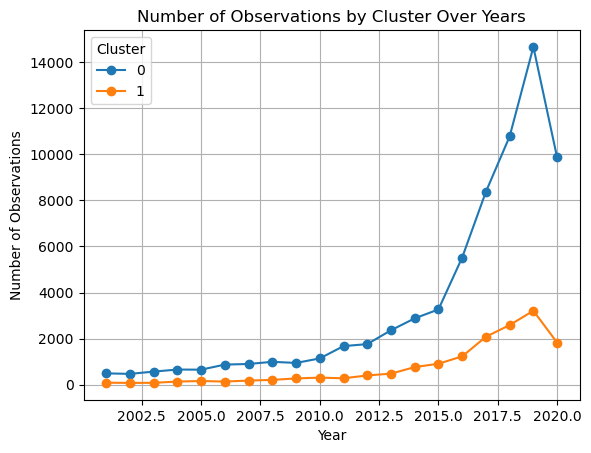

In [70]:
# Looking at the changes for each cluster over the years
yearly_cluster_stats = df.groupby(['year', 'Location_Cluster']).agg({
    'LATITUDE': 'mean',
    'LONGITUDE': 'mean',
    'OBSERVATION COUNT': ['count', 'mean']
}).round(2)

#print("Yearly Distribution of Observations by Cluster:")
#print(yearly_cluster_stats)

# Plot the number of observations per cluster over years
plt.figure(figsize=(12, 6))
cluster_counts = df.groupby(['year', 'Location_Cluster']).size().unstack()
cluster_counts.plot(marker='o')
plt.title('Number of Observations by Cluster Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

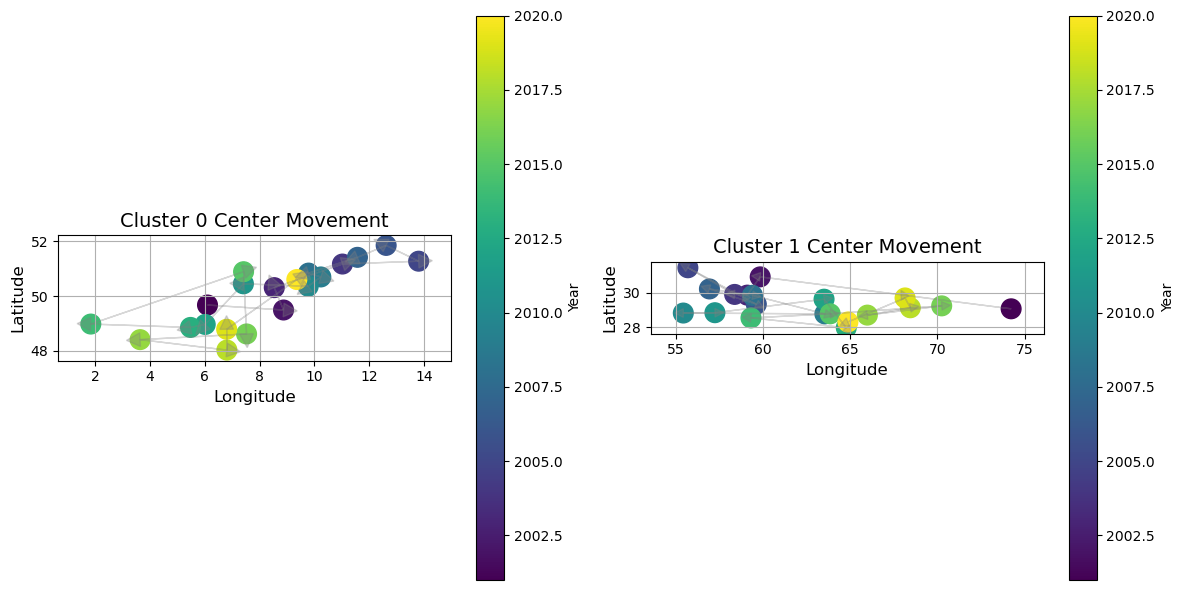


Total displacement (in degrees) for each cluster from first to last year:

Cluster 0 (2001.0 to 2020.0):
Latitude change: 0.93°
Longitude change: 3.26°
Total displacement: 3.39°
Average position: 49.98°N, 8.23°E

Cluster 1 (2001.0 to 2020.0):
Latitude change: 0.75°
Longitude change: 9.36°
Total displacement: 9.39°
Average position: 29.35°N, 62.43°E


In [63]:
# Calculating the yearly average positions for each cluster
yearly_positions = df.groupby(['year', 'Location_Cluster']).agg({
    'LATITUDE': 'mean',
    'LONGITUDE': 'mean'
}).reset_index()

# Create square plots for each cluster's movement with larger size
plt.figure(figsize=(12, 6))

# Plot individual cluster movements
for cluster in range(2):
    cluster_data = yearly_positions[yearly_positions['Location_Cluster'] == cluster]
    
    # Plot the path of the cluster center
    plt.subplot(1, 2, cluster + 1)
    
    # Create a scatter plot with points colored by year
    scatter = plt.scatter(cluster_data['LONGITUDE'], 
                         cluster_data['LATITUDE'],
                         c=cluster_data['year'],
                         cmap='viridis',
                         s=200)  # Increased point size
    
    # Add arrows to show direction of movement
    for i in range(len(cluster_data)-1):
        plt.arrow(cluster_data['LONGITUDE'].iloc[i],
                 cluster_data['LATITUDE'].iloc[i],
                 cluster_data['LONGITUDE'].iloc[i+1] - cluster_data['LONGITUDE'].iloc[i],
                 cluster_data['LATITUDE'].iloc[i+1] - cluster_data['LATITUDE'].iloc[i],
                 head_width=0.5,
                 head_length=0.5,
                 fc='gray',
                 ec='gray',
                 alpha=0.3)
    
    plt.colorbar(scatter, label='Year')
    plt.title(f'Cluster {cluster} Center Movement', fontsize=14)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.grid(True)
    
    # Make the plot more square by setting equal aspect ratio and adjusting limits
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Add some padding to the axes
    x_min, x_max = cluster_data['LONGITUDE'].min(), cluster_data['LONGITUDE'].max()
    y_min, y_max = cluster_data['LATITUDE'].min(), cluster_data['LATITUDE'].max()
    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)

plt.tight_layout()
plt.show()

# Create a world map showing the cluster movements
# Use a more centered initial view and appropriate zoom level
center_lat = yearly_positions['LATITUDE'].mean()
center_lon = yearly_positions['LONGITUDE'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=4)

# Define colors for clusters
colors = ['red', 'blue']

# Add cluster movements to the map
for cluster in range(2):
    cluster_data = yearly_positions[yearly_positions['Location_Cluster'] == cluster]
    
    # Create a feature group for this cluster
    fg = folium.FeatureGroup(name=f'Cluster {cluster}')
    
    # Add points for each year
    for idx, row in cluster_data.iterrows():
        folium.CircleMarker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            radius=8,  # Increased radius
            color=colors[cluster],
            fill=True,
            popup=f'Cluster {cluster}, Year: {row["year"]}<br>Lat: {row["LATITUDE"]:.2f}<br>Lon: {row["LONGITUDE"]:.2f}',
            opacity=0.7
        ).add_to(fg)
    
    # Add lines connecting consecutive years
    points = cluster_data[['LATITUDE', 'LONGITUDE']].values.tolist()
    folium.PolyLine(
        points,
        weight=3,  # Increased line weight
        color=colors[cluster],
        opacity=0.8
    ).add_to(fg)
    
    fg.add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m.save('cluster_movements_map.html')
m  # Display the map in the notebook

# Print the total displacement for each cluster
print("\nTotal displacement (in degrees) for each cluster from first to last year:")
for cluster in range(2):
    cluster_data = yearly_positions[yearly_positions['Location_Cluster'] == cluster]
    first_pos = cluster_data.iloc[0]
    last_pos = cluster_data.iloc[-1]
    
    lat_change = abs(last_pos['LATITUDE'] - first_pos['LATITUDE'])
    lon_change = abs(last_pos['LONGITUDE'] - first_pos['LONGITUDE'])
    total_displacement = np.sqrt(lat_change**2 + lon_change**2)
    
    # Get the first and last year for reference
    first_year = first_pos['year']
    last_year = last_pos['year']
    
    print(f"\nCluster {cluster} ({first_year} to {last_year}):")
    print(f"Latitude change: {lat_change:.2f}°")
    print(f"Longitude change: {lon_change:.2f}°")
    print(f"Total displacement: {total_displacement:.2f}°")
    
    # Print average position
    avg_lat = cluster_data['LATITUDE'].mean()
    avg_lon = cluster_data['LONGITUDE'].mean()
    print(f"Average position: {avg_lat:.2f}°N, {avg_lon:.2f}°E")

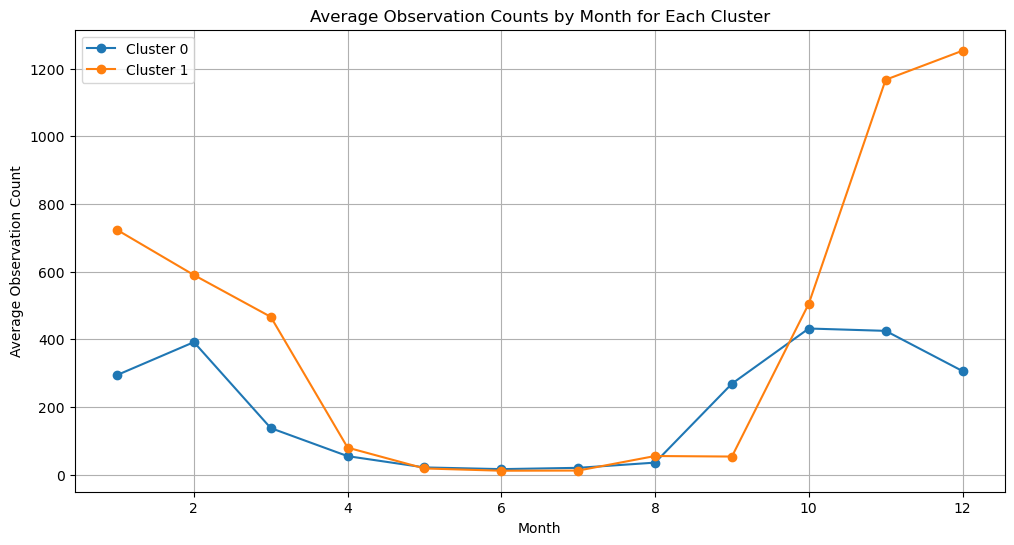

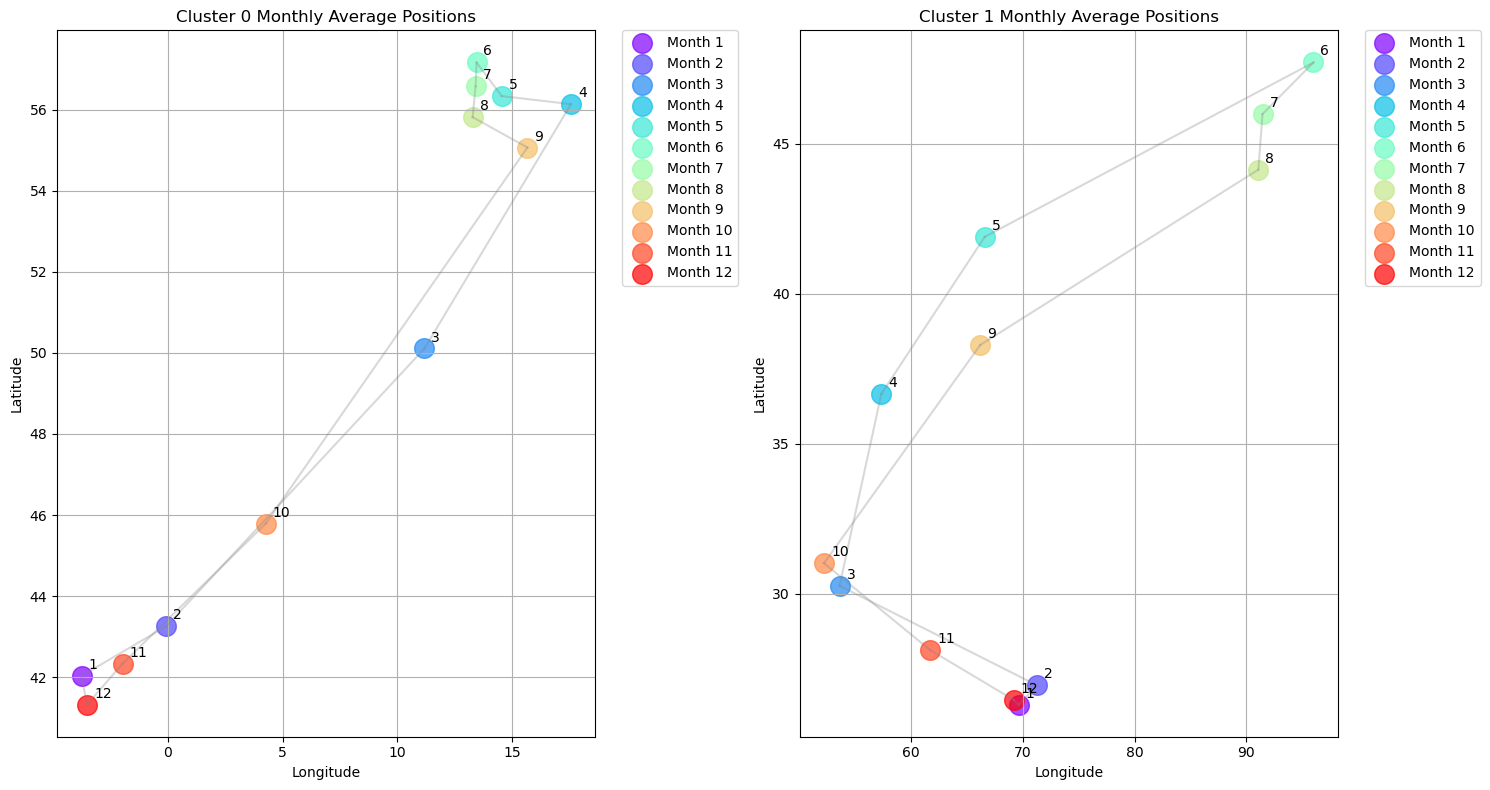

In [72]:
# Monthly analysis
monthly_cluster_stats = df.groupby(['month', 'Location_Cluster']).agg({
    'LATITUDE': 'mean',
    'LONGITUDE': 'mean',
    'OBSERVATION COUNT': ['count', 'mean']
}).round(2)

#print("\nMonthly Distribution of Observations by Cluster:")
#print(monthly_cluster_stats)

# Plot average observation counts by month for each cluster
plt.figure(figsize=(12, 6))
for cluster in range(2):
    cluster_data = df[df['Location_Cluster'] == cluster]
    monthly_means = cluster_data.groupby('month')['OBSERVATION COUNT'].mean()
    plt.plot(monthly_means.index, monthly_means, marker='o', label=f'Cluster {cluster}')

plt.title('Average Observation Counts by Month for Each Cluster')
plt.xlabel('Month')
plt.ylabel('Average Observation Count')
plt.legend()
plt.grid(True)
plt.show()

# Plot each cluster's monthly average positions
plt.figure(figsize=(15, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, 12))  # Different color for each month

for cluster in range(2):  # Changed from range(3) to range(2)
    plt.subplot(1, 2, cluster + 1)  # Changed from 2,2 to 1,2
    
    # Get monthly average positions for this cluster
    cluster_monthly_stats = monthly_cluster_stats.xs(cluster, level='Location_Cluster')
    
    # Plot each month's average position
    for month in range(1, 13):
        month_data = cluster_monthly_stats.loc[month]
        plt.scatter(month_data['LONGITUDE', 'mean'], 
                   month_data['LATITUDE', 'mean'],
                   c=[colors[month-1]],
                   s=200,
                   label=f'Month {month}',
                   alpha=0.7)
        
        # Add month number as text next to point
        plt.annotate(str(month), 
                    (month_data['LONGITUDE', 'mean'], month_data['LATITUDE', 'mean']),
                    xytext=(5, 5), 
                    textcoords='offset points')
        
        # If not the last month, draw line to next month
        if month < 12:
            next_month_data = cluster_monthly_stats.loc[month + 1]
            plt.plot([month_data['LONGITUDE', 'mean'], next_month_data['LONGITUDE', 'mean']],
                    [month_data['LATITUDE', 'mean'], next_month_data['LATITUDE', 'mean']],
                    'gray', alpha=0.3)
    
    # Connect December to January to complete the annual cycle
    plt.plot([cluster_monthly_stats.loc[12]['LONGITUDE', 'mean'], 
              cluster_monthly_stats.loc[1]['LONGITUDE', 'mean']],
             [cluster_monthly_stats.loc[12]['LATITUDE', 'mean'], 
              cluster_monthly_stats.loc[1]['LATITUDE', 'mean']],
             'gray', alpha=0.3)
    
    plt.title(f'Cluster {cluster} Monthly Average Positions')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    
    # Add legend but make it compact
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

In [67]:
# Plotting monthly positions on the map
# Create base map
center_lat = df['LATITUDE'].mean()
center_lon = df['LONGITUDE'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=2)

# Define colors for clusters
colors = ['red', 'blue', 'green', 'purple']

# Create a feature group for each cluster
for cluster in range(2):
    # Get monthly positions for this cluster
    cluster_monthly = monthly_cluster_stats.xs(cluster, level='Location_Cluster')
    
    # Create a feature group for this cluster
    fg = folium.FeatureGroup(name=f'Cluster {cluster}')
    
    # Plot monthly positions
    coordinates = []
    for month in range(1, 13):
        month_data = cluster_monthly.loc[month]
        lat = month_data['LATITUDE', 'mean']
        lon = month_data['LONGITUDE', 'mean']
        coordinates.append([lat, lon])
        
        # Add circle marker for each month
        folium.CircleMarker(
            location=[lat, lon],
            radius=8,
            color=colors[cluster],
            fill=True,
            popup=f'Cluster {cluster}, Month {month}<br>Lat: {lat:.2f}<br>Lon: {lon:.2f}',
            tooltip=f'Month {month}',
            opacity=0.7,
            fill_opacity=0.5
        ).add_to(fg)
        
        # Add month number as text
        folium.Popup(f'Month {month}').add_to(
            folium.CircleMarker(
                location=[lat, lon],
                radius=1,
                color='black',
                fill=False,
            ).add_to(fg)
        )
    
    # Add lines connecting the months
    coordinates.append(coordinates[0])  # Connect back to January
    folium.PolyLine(
        locations=coordinates,
        weight=2,
        color=colors[cluster],
        opacity=0.5,
        popup=f'Cluster {cluster} Monthly Path'
    ).add_to(fg)
    
    fg.add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save the map
m.save('monthly_clusters_map.html')

# Display the map
m